<br><font color='Green' size=5><b><center>MODELLING</center></b></font><br>
<font color='Green' size=3><b><center>Project: Analysis of different measures taken by different countries to control the spread of Covid-19 virus</center></b></font><br>
<font color='Green' size=3><b>Team Members</b></font><br>
<font color='Green' size=3>Nisha Ramrakhyani (Student Id: 801208678)</font><br>
<font color='Green' size=3>Punit Mashruwala (Student Id: 801208416)</font><br>
<font color='Green' size=3>Zalak Panchal (Student Id: 801196881)</font>

**Research Question:**
*How did country level orders impact the proportion of COVID-19 positive cases (among those tested)?  What predictive modeling can be done with the data?*


<font color ='black'>This basic Jupyter Notebook shows exploratory analysis of percent positive COVID cases in Australia (positive cases/number tested) using the time series analysis and forecasting tool from Facebook called Prophet with Python. </font>

In [1]:
# import libraries
import requests
import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import statistics as stat
from pylab import rcParams


In [4]:
from fbprophet import Prophet 
from sodapy import Socrata
from fbprophet.diagnostics import cross_validation 
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import performance_metrics

In [10]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/My Drive/fbaustralia.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
#fb prophet wants specific column headers - date column to be 'ds' and outcome variable to be 'y'
#ds column shows the IMPLEMENTATION DATE of measures taken by Australia and y shows the positivity rate of Covid cases(No. of positive cases/Total tests)
df.head(10)

,ds,y
0,2020-03-29,0.036
1,2020-03-30,0.038
2,2020-03-31,0.034
3,2020-04-01,0.033
4,2020-04-02,0.029
5,2020-04-03,0.027
6,2020-04-04,0.023
7,2020-04-05,0.020
8,2020-04-06,0.018
9,2020-04-07,0.018


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      260 non-null    object 
 1   y       260 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.2+ KB


In [29]:
#Instantiate the Prophet class
p = Prophet()

#Fit the model 
p.fit(df);

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
#Inspect some of the metrics
df.describe()

,y
count,260.000000
mean,0.002969
std,0.005837
min,0.000000
25%,0.000000
50%,0.001000
75%,0.004000
max,0.038000


# Forecast into the future with FB Prophet

In [31]:
#Making a DataFrame with dates in the future using the helper
future = p.make_future_dataframe(periods=60)

#Predicting into the future 
forecast = p.predict(future)

In [32]:
#Inspecting some of the metrics of the predictions
forecast['yhat'].describe()

count    320.000000
mean       0.002297
std        0.005234
min       -0.001009
25%       -0.000062
50%        0.000474
75%        0.002640
max        0.033140
Name: yhat, dtype: float64

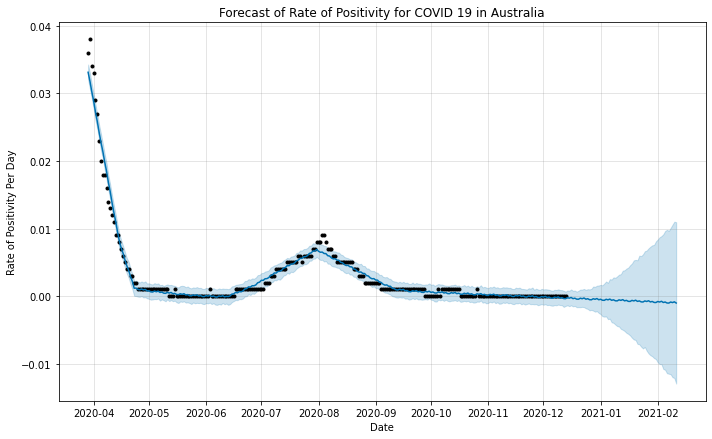

In [33]:
#Plotting the data and predictions with their confidence intervals
fig1 = p.plot(forecast, xlabel = 'Date', ylabel = "Rate of Positivity Per Day")
plt.title("Forecast of Rate of Positivity for COVID 19 in Australia")
plt.savefig('fig1.png', dpi=300, bbox_inches='tight');


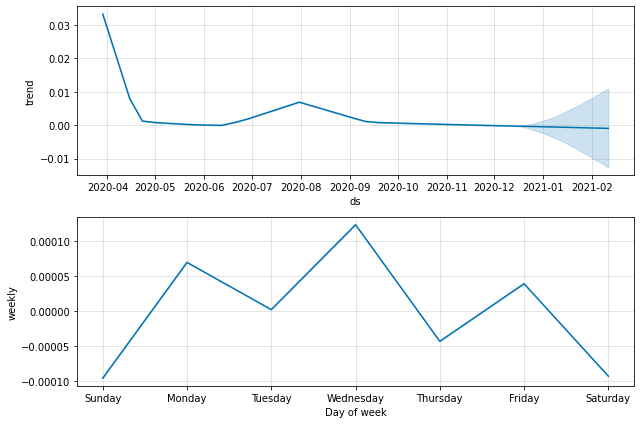

In [34]:
#Examining the components of the forecast with built-in components plot
fig2 = p.plot_components(forecast)
plt.savefig('fig2.png', dpi=300, bbox_inches='tight');

In [35]:
#Performing cross-validation
df_cv = cross_validation(p, horizon = '60 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-10-14 00:00:00 and 2020-10-14 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-15,0.000193,-0.000849,0.001258,0.001,2020-10-14
1,2020-10-16,0.000305,-0.000779,0.001308,0.001,2020-10-14
2,2020-10-17,0.000136,-0.000914,0.001165,0.000,2020-10-14
3,2020-10-18,0.000042,-0.000967,0.001127,0.000,2020-10-14
4,2020-10-19,0.000195,-0.000925,0.001306,0.000,2020-10-14


In [36]:
#We can then calculate metrics such as MAE, MSE, or RMSE with another built-in function.

df_p = performance_metrics(df_cv)
df_p['rmse'].mean()

INFO:fbprophet:Skipping MAPE because y close to 0


0.0006374761475348755

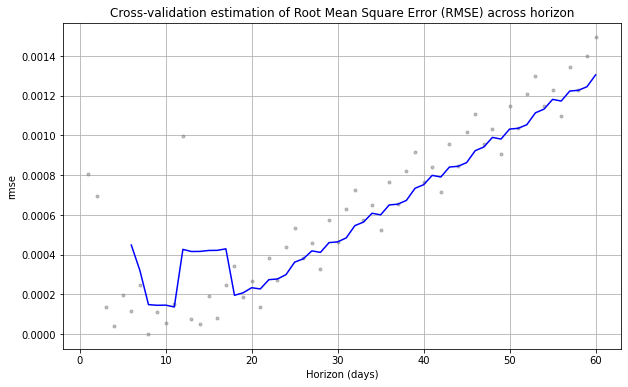

In [37]:
#Finally, we can plot the estimated errors across the horizon. This method includes a rolling calculation across
#10% of the data, represented by the blue line.

fig3 = plot_cross_validation_metric(df_cv, metric='rmse')
plt.title("Cross-validation estimation of Root Mean Square Error (RMSE) across horizon")
plt.savefig("fig3.png", dpi=300, bbox_inches='tight')


In [38]:
#fb prophet has holidays where we can place the interventions
#Adding the below mentioned interventions
#curfew 8/2
#lockdown 8/12
#Limit Public Gatherings 5/18
#Border Closure 3/20
#Closure of businesses 7/1
holidays = pd.DataFrame({
  'holiday': 'intervention',
  'ds': pd.to_datetime(['2020-03-20','2020-05-18','2020-07-01','2020-08-02', '2020-08-12']),
  'lower_window': 0,
  'upper_window': 1,
})


In [39]:
#Adding interventions 
p2 = Prophet(holidays = holidays)
p2.fit(df)
future2 = p2.make_future_dataframe(periods=60)
forecast2 = p2.predict(future2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


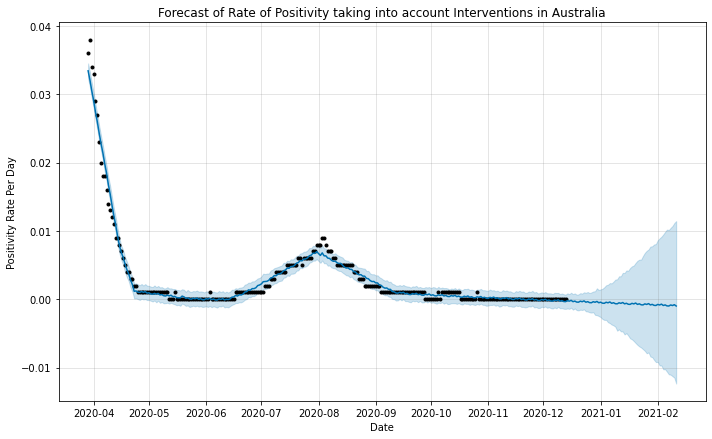

In [40]:
fig4 = p2.plot(forecast2, xlabel = 'Date', ylabel = "Positivity Rate Per Day")
plt.title("Forecast of Rate of Positivity taking into account Interventions in Australia")
plt.savefig('fig4.png', dpi=300, bbox_inches='tight');


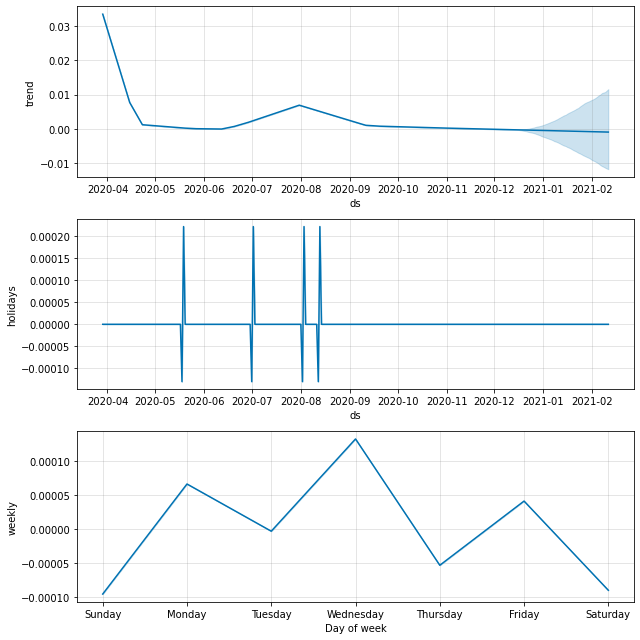

In [41]:
#Examining the components of the forecast with built-in components plot
fig5 = p2.plot_components(forecast2)
plt.savefig('fig5.png', dpi=300, bbox_inches='tight');

INFO:fbprophet:Making 1 forecasts with cutoffs between 2020-10-14 00:00:00 and 2020-10-14 00:00:00


INFO:fbprophet:Skipping MAPE because y close to 0


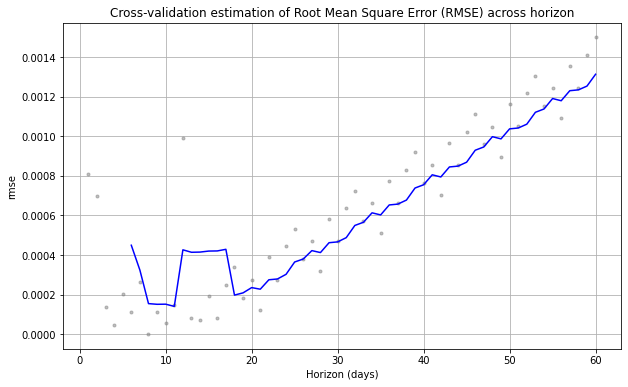

In [42]:
df_cv2 = cross_validation(p2, horizon = '60 days')
df_p2 = performance_metrics(df_cv2)
fig6 = plot_cross_validation_metric(df_cv2, metric='rmse')
plt.title("Cross-validation estimation of Root Mean Square Error (RMSE) across horizon")
plt.savefig("fig6.png", dpi=300, bbox_inches='tight')